# Creant el teu Graph de Twitter!

**[How to download and visualize your Twitter network](https://towardsdatascience.com/how-to-download-and-visualize-your-twitter-network-f009dbbf107b)**

[Creating Beautiful Twitter Graphs with Python](https://towardsdatascience.com/creating-beautiful-twitter-graphs-with-python-c9b73bd6f887)

[Exploring a Twitter Network with Memgraph in a Jupyter Notebook](https://memgraph.com/blog/jupyter-notebook-twitter-network-analysis)

<div class="alert alert-info alert-info"><b><h1>Quin és l'objectiu?</h1></b>

Tal com hem vist, els <b>graphs</b> són una estroctura matemàtica per representar relacions entre elements. Aquests elements estàn formats per nodes i vertex. En el nostre cas, utilitzarem Twitter per crear el que es diu "Social network analysis"
    
El <b>Social network analysis</b> és el process d'analitzar estroctures socials a partir de xarxes i la teoria dels graphs. Per tal de fer-ho, els nodes representaran, en aquest cas, contes de Twitter. Els vertex seràn representats per la relació o iteracció entre aquests nodes a la xarxa social.
    

<div class="alert alert-success alert-success"><b><h1>1. Twitter API</h1></b>

El primer pas serà aconseguir les credencials per poder extreure les dades. <a href='https://developer.twitter.com/en/docs/twitter-api'> Aconseguir credencials </a> 

Utilitzarem la llibreria <b>tweepy</b> per connectar-nos a la API de Twitter. Aquesta ens permet utilitzar l'api de froma senzilla, cridant els seus mètodes.
    
El codi següent està pensat per llegir un arxiu JSON anomenat 'twitterkey.json' amb la informació necessaria per accedir a la API. Aquest arxiu s'ha de trobar a la mateixa carpeta que aquest notebook. A dins hi ha d'haver el següent:
    
<code>
{"consumer_key": "consumer_key_string",
"consumer_secret": "consumer_secret_string",
"access_token_key": "access_token_key_string",
"access_token_secret": "access_token_secret_string"}</code>

</div>

### Json data

In [2]:
import tweepy
import json

f = open('twitterkey.json')
credentials = json.load(f)

auth = tweepy.OAuthHandler(credentials['consumer_key'],credentials['consumer_secret'])
auth.set_access_token(credentials['access_token_key'],credentials['access_token_secret'])
 
api = tweepy.API(auth, wait_on_rate_limit=True)
 
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed authentication')

Successful Authentication


<div class="alert alert-success alert-success"><b><h1>2. Aconseguir la informació dels seguidors fent servir Tweepy</h1></b>

El nostre objectiu és representar les relacions entre una conta i els seguidors. Primerament el que farem és seleccionar un usuari i extreure el seu id. A partir d'aqui, començarem extraient els seus seguidors.  </div>

In [3]:
me = api.get_user(screen_name = 'telecogresca')
me.id ## id de la compta @telecogresca

130582940

<div class="alert alert-warning alert-warning"> <b>Fixa't que hi ha un límit a les consultes. Si la conta que utilitzes té molts followers, anirà fent consultes fins arribar al límit, i seguidament pararà uns minuts fins tornar a consultar de nou. És millor fer aquest experiment amb la teva conta personal o una conta amb no molts seguidors. </b> </div>

In [4]:
user = me.id ## Podem fer una llista d'usuaris per començar
follower_list = [] ## Array buida on anirem posant els followers

followers = []
try:
    for page in tweepy.Cursor(api.followers_ids, user_id=user).pages():
        followers.extend(page)
        print(len(followers))
except:
    print("error")
    
follower_list.append(followers)

3623


<div class="alert alert-success alert-success"><b><h1>3. Posar les dades en un dataframe</h1></b>

Anem a crear un graph senzill. Anem a utilitzar com a nodes els usuaris i la relació serà 1-1. Aquesta gràfica no és de les més interessants, però està bé per començar a visualitzar el que hem creat.

<ul><li>1. El primer pas serà posar les dades trobades en un dataframe. "Source" serèm nosaltres, el node principal, i "Target" seran els següidors</li>
    <li>2. Utilitzarem la llibreria networkx per representar el gràfic </li></ul></div>

In [5]:
import pandas as pd
import networkx as nx

In [6]:
df = pd.DataFrame(columns=['source','target']) #Empty DataFrame
df['target'] = follower_list[0] #Set the list of followers as the target column
df['source'] = me.id #Set my user ID as the source 

In [7]:
df.head()

,source,target
0,130582940,1592486909007351809
1,130582940,1375573718882250756
2,130582940,919880348
3,130582940,1483353837545132040
4,130582940,1488116528008646656


<div class="alert alert-warning alert-warning">
<b>Gràfica</b>

Per crear aquesta gràfica, utilitzarem la llibreria <b>networkx</b>. Com no indiquem els pesos, la distancia entre nodes serà la mateixa!
    
Si t'interessa veure altres layauts, pots consultar el següent [link](https://networkx.org/documentation/stable/reference/drawing.html)
</div>

In [26]:
G = nx.from_pandas_edgelist(df, 'source', 'target') #Turn df into graph
pos = nx.spring_layout(G) #specify layout for visual, pos és la posisió dels nodes

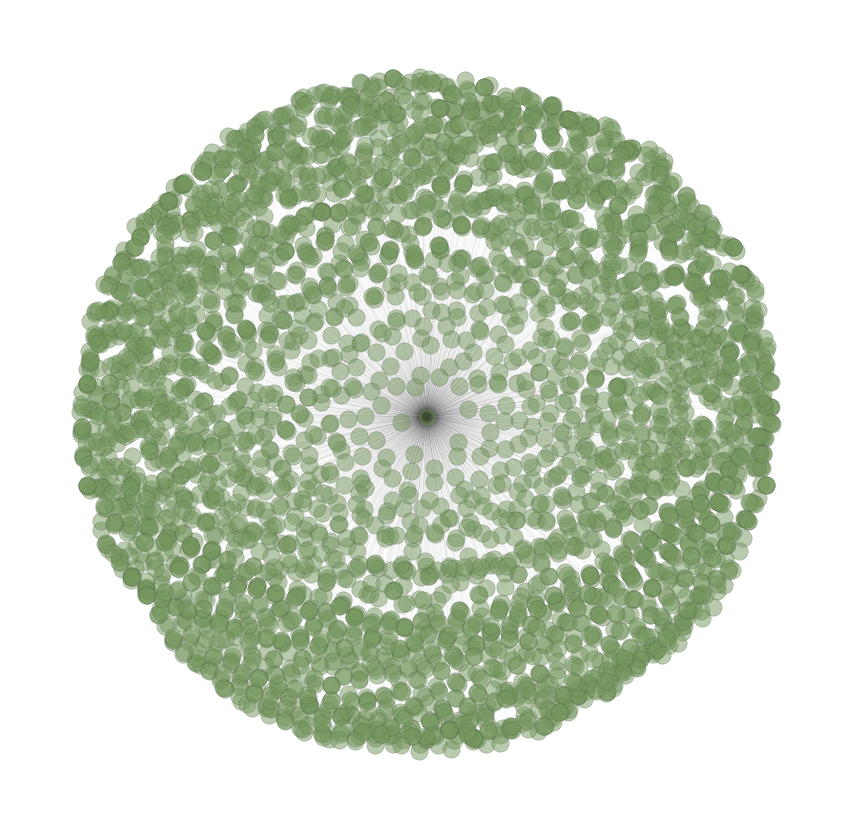

In [32]:
import matplotlib.pyplot as plt ## import llibreria


f, ax = plt.subplots(figsize=(15, 15)) ## Tamany plot
ax.set_facecolor('white') ## Fons blanc

plt.style.use('ggplot') ## Diem que serà un graph


nodes = nx.draw_networkx_nodes(G, pos, alpha=0.5, node_color='#75975e') ## nodes
nodes.set_edgecolor('#4b6043')
#nx.draw_networkx_labels(G, pos, font_size=3) ## Descomenta per visualitzar l'ID dels usuaris
nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.1) ## edges

<div class="alert alert-success alert-success"><b><h1>4. Seguidors dels seguidors</h1></b>

El que ens interessa arribar a tenir és els seguidors del nostre node principal. Per fer-ho, farem un loop que mira els followers i els guardarem al nostre dataframe. Aquest codi el podem correr tans cops com volguem. Això craria una xarxa molt més gran, però ves en compte, ja que el nostre objectiu és trobar un graph pròpi, si comences a buscar seguidors de seguidors, és possible que aquests graphs siguin molt pesats. Et recomano nomès correr aquest codi un cop!

<b> És important tenir en compte que Twitter API limita en nombre de trucades. Per tant si la teva xarxa és molt gran, és possible que estiguis una bona estona, ja que t'has d'esperar 15 min entre trucada i trucada! A més, nomès agafarem els 5000 primers followers, per agilitzar la feina!</b></div>

<div class="alert alert-warning alert-warning">
<b>Atenció!</b>
Fixa't que si t'aburreixes, pots parar el procés en qualsevol moment, les dades es van guardant en un CVS! Però la teva xarxa quedarà incompleta!
</div>

In [ ]:
user_list = list(df['target']) #Use the list of followers we extracted in the code above
for userID in user_list:
    print(userID)
    followers = []
    follower_list = []

    # fetching the user
    user = api.get_user(userID)

    # fetching the followers_count
    followers_count = user.followers_count

    try:
        for page in tweepy.Cursor(api.followers_ids, user_id=userID).pages():
            followers.extend(page)
            print(len(followers))
            if followers_count >= 5000: #Only take first 5000 followers
                break
    except tweepy.TweepError:
        print("error")
        continue
    follower_list.append(followers)
    temp = pd.DataFrame(columns=['source', 'target'])
    temp['target'] = follower_list[0]
    temp['source'] = userID
    df = pd.concat([df, temp])
    df.to_csv("networkOfFollowers.csv")

1375573718882250756
149
919880348
35
1483353837545132040
182
1488116528008646656
138
288500145
311
1559847021502136321
6
82041749
5000
2286487057
5000
17896683
2929
272281656
728
913736527657799680
17
1509863829815111684
78
1527372918199447552
9
1523715455638253568
106
1041511908
79
1519945547158859777
error
1520503899714723840
66
1505569065598861319
33
266568867
835
14047971
5000
200927550
134
2228188124
234
1503792194368548873
15
1267911393552072706
56
558820425
355
1056679268284030978
65
744811962828128256
360
2157665135
208
329621326
139
767329339981623296
40
1510195027645018119
1
516089258
675
1347088946438803458
35
995668903
19
1494338242144993288
90
813882209715232768
1481372633295998981
2
1096485349633769473
86
1370113330652798980
34
558854512
235
748091659175485440
42
264490444
214
1405112012863115268
2910064911
1
1508495700908290055
27
1155803038151512064
116
1488072291795746818
1944813044
2857
957237770765955072
280
1146095842761293824
94
1479168329654931457
35
1439268005356

1551
253650939
674
86585249
845
787597066843332608
17
2516496869
61
1027170331549687809
107
2986061735
199
152612622
193
1049786662803427329
99
145277650
error
714898149828112385
error
837023226777718784
582
896059800907395078
3135
279041029
111
274742811
49
150834811
102
3461080168
343
3179861519
665
1059106601016180736
675
2331796649
517
919720362
24
824751597246935040
88
597332378
78
705795349
70
95224291
184
624831274
22
3160963936
673
196161136
426
1109931475376451584
19
846865475623636992
127
478780064
162
1083784644447928321
145
4896203818
201
2238155017
503
1667411526
5000
228853211
207
1329919885
313
882840817949454337
50
1379859552
128
1106265471828008960
72
3543404475
5000
1688553121
73
912723255408152576
13
325089412
449
1103975527323443200
741
1103265420868493312
13
818447429771083776
234
898323661245034496
35
1099083061894021123
108
1038805100230324224
40
502396195
40
519547489
270
264266850
294
238547567
1790
943596559
3629
521409113
294
269702022
85
3342487444
224
56405

error
238307433
45
375754564
182
306464226
73
834129703254515712
40
798123187
69
921714869069647874
64
914823183240515584
21
3061632106
75
383436806
37
748285430
99
235436087
83
447460636
233
436779980
66
913324176018149376
72
907902658769547269
10
910492923652960256
27
910871599489982464
4
788845174457851905
14
164729685
1976
791179206
126
359572899
130
2839990071
error
898893547646181377
32
1148209152
error
894514476711542785
37
889224905396506627
58
845471982
error
2294433970
135
3345273221
3999
876453752005439488
19
864720970556334080
287
110515420
1982
1251092803
1374
871505783040724992
668
2648474198
44
701490767
334
866055492472274949
8
4328039002
246
2178488261
122
2525492850
174
4887776950
161
141736644
285
806936894604984320
5
1066277888
357
3728348777
20
281102283
1379
853253024877342721
69
851377436621246466
82
404936529
471
299300002
5000
1240965553
2398
820342960231448577
error
1588252718
58
779668359818383360
54
3557863695
20
796618014
272
1894688462
2737
2287179528
111


<div class="alert alert-success alert-success"><b><h1>5. Social graph!</h1></b>
    
Ara és moment de representar la nostra gràfica social. Primerament llegirem la nostra base de dades <b>networkOfFollowers.csv</b>. Aqui tenim nous nodes, dels contactes propers i dels seguidors d'aquests. Anem a representar les interaccions socials!
</div>

In [82]:
df = pd.read_csv('networkOfFollowers.csv') #Read into a df
df.source = df.source.astype('int64')
df.target = df.target.astype('int64')
G = nx.from_pandas_edgelist(df, 'source', 'target') ## Create graph

In [83]:
G.number_of_nodes() #Find the total number of nodes in this graph

356297

<div class="alert alert-info alert-info"><b><h1>Com masurarem la distància entre els nodes?</h1></b>
    
Com hem vist anteriorment, els graphs es representen entre els nodes i les arestes. Els nodes són representats pels usuaris i la aresta dependrà de la interpretació que volguem fer de la xarxa. Anteriorment, la aresta representava una relació 1-1, on era la representació seguidor, i la distància és la mateixa. Cada node tenia el mateix pes, ja que no hi havia usuaris de més importància que d'altres.

En aques cas el que volem és trobar quins nodes són els més influencials, per tant aquests que tenen molts seguidors i a la vagada molta gent els segueix. Per fer-ho, utilitzarem Degree Centrality, que és una masura de centralitat, on ens dona una funció del nombre de conneccions que el node te. 
    

</div>

In [84]:
df_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
df_sorted.columns = ['node','degree']
df_sorted.head()

,node,degree
0,339548478,5034
1,1327007952,5032
2,216639700,5030
3,129596166,5017
4,4841444607,5014


<div class="alert alert-warning alert-warning">
Si vols trobar els nodes amb més degree, pots fer servir el següent codi:
</div>

In [85]:
u = api.get_user(df_sorted.loc[2]['node'])
u.screen_name

'carnetjove_cat'

<div class="alert alert-warning alert-warning">
<b>Cuidado!</b> Si la teva xarxa és molt gran, es necessitarà molt temps per representar-la, cosa que no ens interessa massa. 
Evita-ho eliminant tot aquell node que tingui un degree menor a 10
</div>

In [86]:
G = nx.k_core(G, 10) #Exclude nodes with degree less than 10

<div class="alert alert-info alert-info"><b><h1>Com representem les diferents comunitats socials?</h1></b>
    
Hem comentat que els nodes que tinguin més interacció entre ells es representaràn més propers, però a més és possible dividir aquestes comunitats. Per fer-ho, utilitzarem <a href="https://python-louvain.readthedocs.io/en/latest/api.html"><b>community_louvain</b></a>, que ens permet fer aquesta divisió dels nodes en diferents grups. Aquesta divisió es fa mitjançant <b> community detection algorithm</b>

</div>


 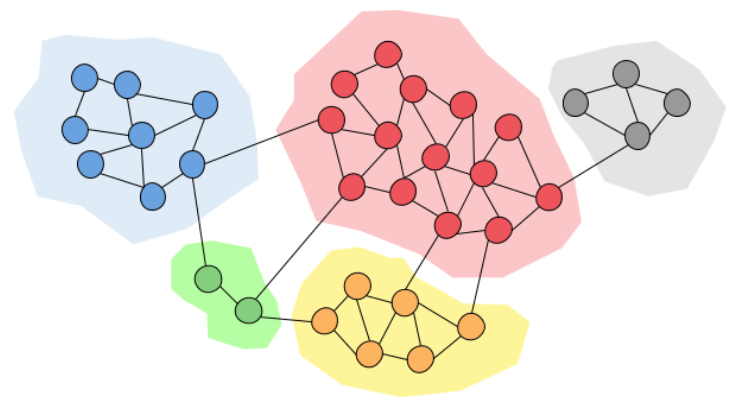

In [87]:
from community import community_louvain

partition_louvain = community_louvain.best_partition(G)
#Turn partition into dataframe
partition = pd.DataFrame([partition_louvain]).T
partition = partition.reset_index()
partition.columns = ['names','group']

In [88]:
partition.head()

,names,group
0,1520503899714723840,0
1,1505569065598861312,1
2,1281568913269153792,2
3,888174812094504960,2
4,1246923177743220736,1


<div class="alert alert-info alert-info">
    
Necessitem tornar a buscar quin és el degree, ja que la nostra xarxa ha passat a ser menys nodes
</div>


In [89]:
df_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
df_sorted.columns = ['names','degree']
df_sorted.head()

,names,degree
0,130582940,649
1,299300002,342
2,167335610,312
3,250621001,266
4,59753785,263


<div class="alert alert-info alert-info">
Ara creem la base de dades completa, amb el node, el degree i la partició creada
</div>


In [90]:
combined = pd.merge(df_sorted, partition, how='left', left_on="names",right_on="names")

In [91]:
combined.head()

,names,degree,group
0,130582940,649,6
1,299300002,342,3
2,167335610,312,1
3,250621001,266,3
4,59753785,263,1


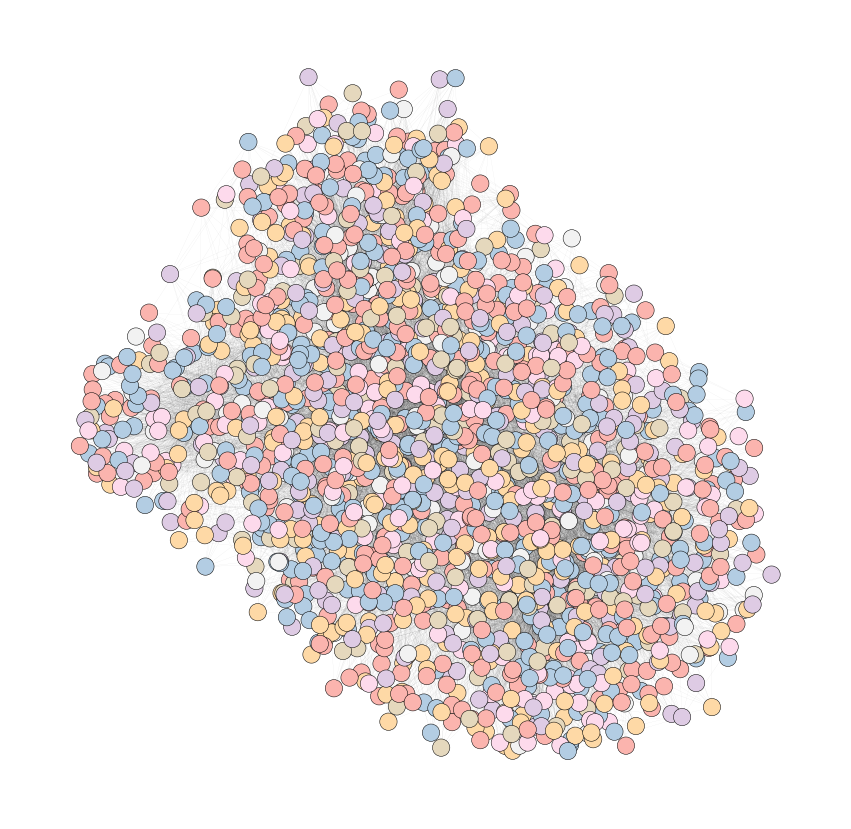

In [99]:
import matplotlib.pyplot as plt ## import llibreria

pos = nx.spring_layout(G)
f, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('white')
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               cmap=plt.cm.Pastel1,
                               node_color=combined['group'],
                               alpha=1)
nodes.set_edgecolor('k')
#nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.2)
plt.savefig('twitterFollowers.png')

<div class="alert alert-success alert-success"><b><h1>6. Conclusions</h1></b>
    
Com pots observar, aqui veiem els nodes superposats, ja que les conneccions entre ells són molt dificins de representar utilitzant matplotlib. Segurament, amb una base de dades més petita, d'un usuari amb menys connexions, pots visualitzar més fàcilment les diferents connexions. Per exemple, aqui hi ha representada una gràfica d'una xarxa social personal:
</div>

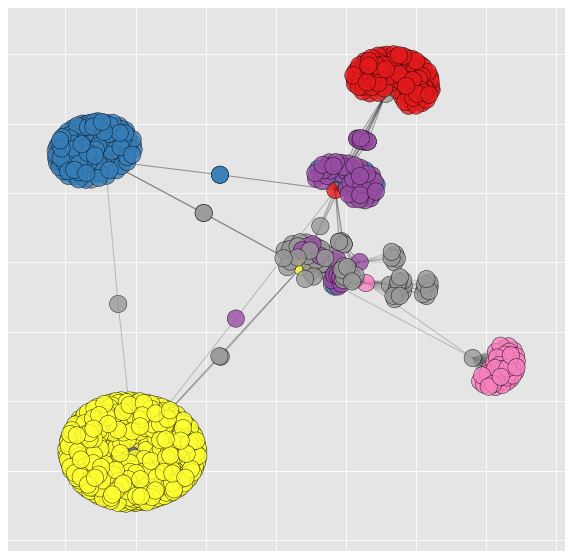

<div class="alert alert-success alert-success">
    
Aqui veiem molt millor representats els grups socials, ja que els diferents agrupacions tenen més distància entre elles.
    
Per poder visualitzar millor, necessitarem millors eines.

</div>

<div class="alert alert-success alert-success"><b><h1>7. Gephi</h1></b>
    
Si vols graficar de forma professional, podem utilitzar l'aplicació Gephi. Aqui pots importar els teus nodes i edges i crear visualitzacions com aquestes:
    
</div>

In [114]:
combined = combined.rename(columns={"names": "Id"}) #I've found Gephi really likes when your node column is called 'Id'
edges = nx.to_pandas_edgelist(G)
edges = edges.rename(columns={"source": "Source",'target':'Target'})

edges.to_csv("edges.csv", index=False)
combined.to_csv("nodes.csv", index=False)

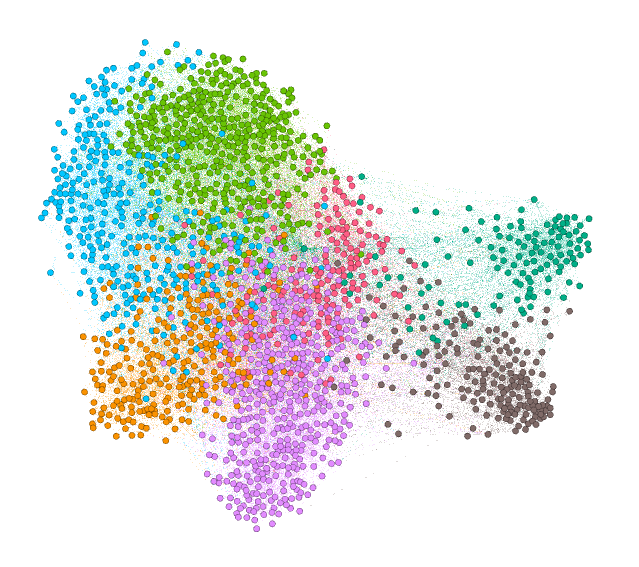

<div class="alert alert-info alert-info">
Aqui podem veure, utilitzant el mètode "ForceAtlas2" de Gephi, els diferents grups! A més, podem visualitzar els nodes més importants!

Telecogresca està representat com el node més gran!
</div>

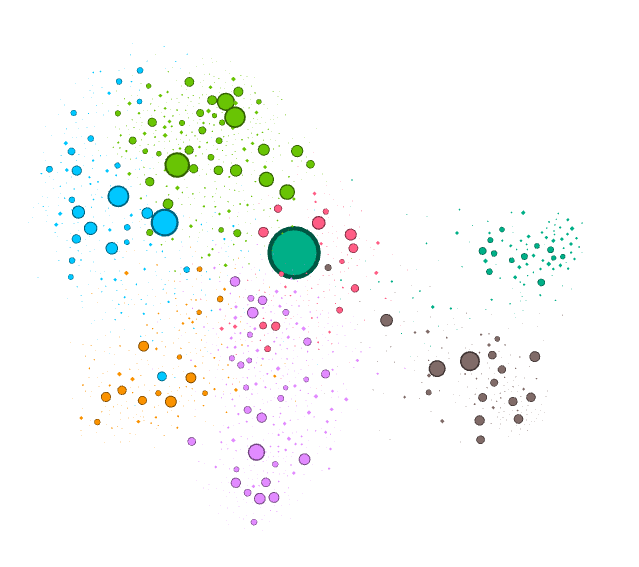

<div class="alert alert-danger" role="alert"><b><h1>Exercici 1</h1></b>
    
Digues quin és el node amb més degree de cada classe i a quina conta de twitter pertany!
</div>


<div class="alert alert-danger" role="alert"><b><h1>Exercici 2</h1></b>

Com ho faries per incloure el nom de l'id de cada un dels nodes a la base de dades?
</div>
